This notebook outlines a complete working example of applying remove_starfield to PSP/WISPR data. The goal is not to provide an example runnable by every curious user, as it requires the full set of WISPR images as well as instrument-specific utilities and pre-processing, which are both outside the scope of this package. Instead, the goal is to show the overall use of the package, and to outline some instrument-specific processing steps to provide ideas for applications to other imagers.

Again, this notebook **cannot** be run top-to-bottom---this is an outline of a solution, not a complete solution.

There's a lot of pre-processing required for WISPR, so I save the pre-processed images to disk for later use in starfield estimation.

Steps include:

* Removal of the F corona (achieved by using WISPR team's L3 images)
* Identification of streaks in each image, saved as mask files
* Regularization of the PSF, using `regularizepsf`
* Realignment of the images for more deeply sub-pixel accuracy
* A "flattening" of each image, which involves fitting a 2D linear function to the (non-masked, non-outlier) pixels in a small sliding window. At each pixel, the fitted function's value at that pixel (fitted to a window centered on that pixel) is subtracted from the pixel. This achieves two goals: 1) compensating for a varying uniform background level across PSP encounters, and 2) fitting and removing the smoother portions of the K corona, to produce cleaner samples of stellar brightnesses in those regions.

Pre-processing can be done as a separate stage, saving the pre-processed files to disk, or it can be done "live" as images are loaded in for the starfield estimation. It may be helpful to pre-compute more intensive steps and do simpler steps "live". Another rule of thumb is that any processing which must also be done to the images from which the starfield estimate will be subtracted should be done "live" in the ImageProcessor subclass, and anything that's specific to the starifeld estimation stage might be better off in a separate stage. Steps that must be done to both (inputs to starfield estimation and inputs to starfield subtraction) may include things such as regularizing the PSF---as this step affects the shapes of stars, and so it must be done always, or the starfield estimation won't match the images it's being subtracted from.

In [2]:
import remove_starfield

from itertools import repeat
import warnings

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regularizepsf
import scipy.ndimage
from tqdm.contrib.concurrent import process_map

# WISPR-specific tools, not included in this package
from wispr_analysis import data_cleaning, planets, utils

# Defining `ImageProcessor`

Here we define an `ImageProcessor` that contains all the instrument-specific logic for loading and preparing WISPR images, and which is designed to support both the "estimating the starfield" and "subtract the starfield" stages.

Note again that this depends on WISPR-specific tools, re-processed WISPR files, and other data products, which are not included in this package and are not all currently available publicly. This is just an outline of the steps required for WISPR data, to inspire you to consider implementing similar steps for your data.

In [ ]:
# WISPR images are normalized for the Sun--spacecraft distance, and we'll need to be able to undo that for star photometry
def denormalize_l3(data, hdr):
    data *= (.2 * u.au.to(u.m) / hdr['dsun_obs']) ** 2.3
    return data

def renormalize_l3(data, hdr):
    data /= (.2 * u.au.to(u.m) / hdr['dsun_obs']) ** 2.3
    return data

# These are for regularizing the WISPR PSF throughout the image plane and across the two detectors.
array_corrector_i = regularizepsf.corrector.ArrayCorrector.load('psf-inner.psf')
array_corrector_o = regularizepsf.corrector.ArrayCorrector.load('psf-outer.psf')
ALPHA = 6
EPSILON = .2

class WISPRImageProcessor(remove_starfield.ImageProcessor):
    def __init__(self, mask=True, denormalize_input=False, renormalize_starfield=False, IO='I'):
        # Whether to apply a mask (replacing masked pixels with NaNs)
        self.mask = mask
        # Whether to undo the normalization for Sun--PSP disance
        self.denormalize_input = denormalize_input
        # Whether starfield samples should receive a Sun--PSP distance normalization,
        # so they can be subtracted from images that haven't been denormalized
        self.renormalize_starfield = renormalize_starfield
        # Whether we're working with the inner or outer detector
        self.IO = IO
    
    def load_image(self, filename):
        # This is pretty standard for WISPR---we just load the data, extract the correct WCS,
        # and store some metadata for later
        with utils.ignore_fits_warnings(), fits.open(filename) as hdul:
            hdu = 1 if hdul[0].data is None else 0
            hdr = hdul[hdu].header
            wcs = WCS(hdr, hdul, key='A')
            data = hdul[hdu].data
        holder = remove_starfield.ImageHolder(data, wcs, hdr)
        # Stash this data for later stages
        holder.filename = filename
        return holder
        
    def preprocess_image(self, image_holder):
        image = image_holder.data
        # Undo the L3s' normalization for s/c distance
        # (Already done in pre-filter stage, but needed for the
        # more pristine images from which we'll subtract the starfield)
        if self.denormalize_input:
            denormalize_l3(image, image_holder.meta)

        # Apply a PSF correction
        corrector = array_corrector_i if self.IO == 'I' else array_corrector_o
        # PSF regularization doesn't work with NaNs, but save them for the mask stage later
        nans = ~np.isfinite(image)
        np.nan_to_num(image, nan=0, posinf=0, neginf=0, copy=False)
        corrected_image = corrector.correct_image(image.astype(float), alpha=ALPHA, epsilon=EPSILON)
        
        if self.mask:
            # Load the pre-computed debris-streak mask
            E = utils.extract_encounter_number(image_holder.filename)
            mask_dir = f'/home/svankooten/psp/WISPR/debris_masks/E{E} masks'
            mask = data_cleaning.find_mask(mask_dir, image_holder.filename)
            mask = fits.getdata(mask).astype(bool)

            # Re-apply this mask from the PSF regularization stage
            mask += nans

            if self.IO == 'I':
                # Apply a bad-pixel mask to the inner detector
                with np.load('bad_pixel_mask.npz') as bad_pixel_map:
                    mask += bad_pixel_map['map']

            # Locate the planets and mask them out
            planet_poses = planets.locate_planets(image_holder.meta)
            with warnings.catch_warnings():
                warnings.filterwarnings(action='ignore', message=".*failed to converge to the requested accuracy.*")
                warnings.filterwarnings(action='ignore', message=".*All-NaN slice encountered.*")
                xs, ys = image_holder.wcs.world_to_pixel(SkyCoord(planet_poses))
            for x, y in zip(xs, ys):
                if np.isnan(x) or np.isnan(y):
                    continue
                x, y = int(x), int(y)
                if 0 <= x < mask.shape[1] and 0 <= y < mask.shape[0]:
                    d = 15
                    left = max(x-d, 0)
                    right = min(x+d, mask.shape[1])
                    bottom = max(y-d, 0)
                    top = min(y+d, mask.shape[0])
                    mask[bottom:top, left:right] = 1

            # For the debris streaks and bad pixels, the PSF regularization spreads the
            # impact to nearby pixels, so we must spread the mask as well.
            mask = corrector.correct_image(mask.astype(float), alpha=ALPHA, epsilon=EPSILON)
            mask = mask > .1

            # Finally, apply the mask to the image, by setting masked pixels to NaN.
            corrected_image[mask] = np.nan

            # Clip the edges, where various artifacts occur,
            # and detect any mostly-NaN or mostly-zero rows or columns and mask them completely.
            # (This occurs in some encounters with big blocks at top or bottom)
            # N.b. check for zeros in the un-psf-corrected image, as after correction
            # zeros aren't exactly zeros
            left = 25
            while (np.sum(mask[left]) / mask[left].size > .8
                    or np.sum(image[left] == 0) / image.shape[0] > .8):
                left += 1
            
            right = corrected_image.shape[0] - 1 - 45
            while (np.sum(mask[right]) / mask[right].size > .8
                    or np.sum(image[right] == 0) / image.shape[0] > .8):
                right -= 1
            
            corrected_image = corrected_image[left:right+1]
            image_holder.wcs = image_holder.wcs[left:right+1]
            image = image[left:right+1]
            
            bottom = 25
            while (np.sum(mask[:, bottom]) / mask[:, bottom].size > .8
                    or np.sum(image[:, bottom] == 0) / image.shape[1] > .8):
                bottom += 1
            
            top = corrected_image.shape[1] - 1 - 25
            while (np.sum(mask[:, top]) / mask[:, top].size > .8
                    or np.sum(image[:, top] == 0) / image.shape[1] > .8):
                top -= 1
            
            corrected_image = corrected_image[:, bottom:top+1]
            image_holder.wcs = image_holder.wcs[:, bottom:top+1]
        
        image_holder.data = corrected_image
        return image_holder
        
    def postprocess_image(self, processed_image, processed_wcs, image_holder):
        # Largely-negative values in an input image likely indicate a region where
        # the background has been oversubtracted. Negative values very close to
        # zero are likely statstically-zero pixels which the noise tipped negative
        # (given the large background that's been subtracted). As heuristics,
        # leave the very close to zero pixels alone, mask (set to NaN)
        # mediumly-negative pixels, and mask the binary closing of the very
        # negative pixels. (The binary closing effectively fills in holes in a
        # region, so this will mask stars that occur within these oversubtracted
        # regions, as the flux values are surely also over-subtracted)
        oversubtractions = processed_image < -3e-12
        oversubtractions = scipy.ndimage.binary_closing(oversubtractions, iterations=30)
        oversubtractions += processed_image < -2e-12
        processed_image[oversubtractions] = np.nan
        return processed_image

    def postprocess_starfield_estimate(self, starfield_estimate, input_image_holder):
        if self.renormalize_starfield:
            # If we don't want to denormalize the image we're subtracting stars from,
            # we'll have to normalize the starfield to match
            renormalize_l3(starfield_estimate, input_image_holder.meta)
        return starfield_estimate

# Running the starfield estimation

Here we assemble a list of input files, and then run the starfield estimation

In [16]:
# Collect input files starfield estimation
ifiles = []
ofiles = []
for E in range(4, 15):
    files = utils.collect_files(f'/home/svankooten/psp/WISPR/prefiltered_images/WISPR_ENC{E:02d}_L3_FITS/')
    # Inner WISPR imager
    ifiles.extend(files[0])
    # Outer WISPR imager
    ofiles.extend(files[1])

starfield = remove_starfield.build_starfield_estimate(
    ifiles, attribution=True, frame_count=True,
    dec_bounds=(-50, 40), processor=WISPRImageProcessor(), target_mem_usage=20)

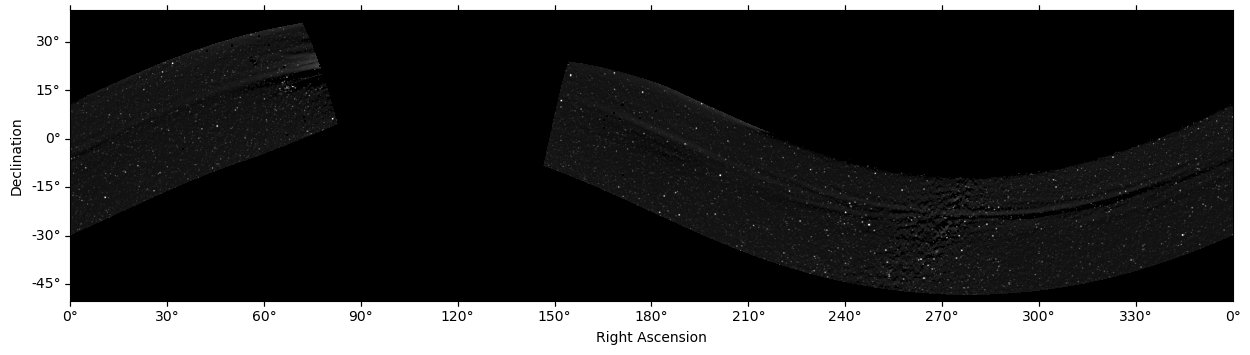

In [8]:
plt.figure(figsize=(15,5))
starfield.plot(pmin=5)

Look, it's a starfield!

Visible artefacts include

* the central gap, representing the portion of each PSP encounter when WISPR isn't imaging
* The remnant coronal features immediately to the left of the gap, showing stars which are only seen very close to the Sun, through persistent coronal features
* A band about a third of the way down the starfield, following the sinusoidal shape of the overall image, representing the PSP orbital plane, which is Venus's orbital plane and is close to the solar equitorial plane. The features seen in the starmap are likely dust in Venus's orbit, or the heliospheric plasma sheet, either of which would be a persistent foreground signal that's not easily separated from the stars.

In [ ]:
starfield.save('starfield-estimate')

In [5]:
starfield = remove_starfield.Starfield.load('starfield-estimate')

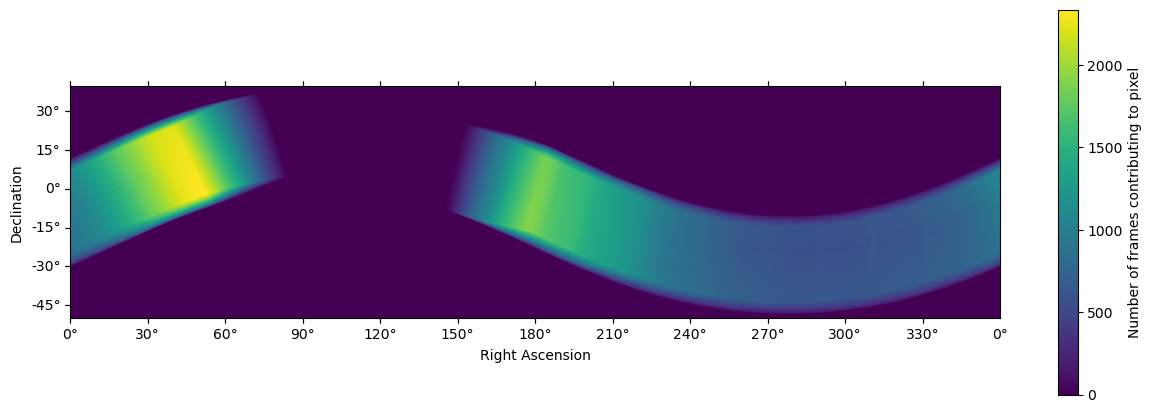

In [50]:
plt.figure(figsize=(15,5))
starfield.plot_frame_count()
plt.colorbar(label='Number of frames contributing to pixel')

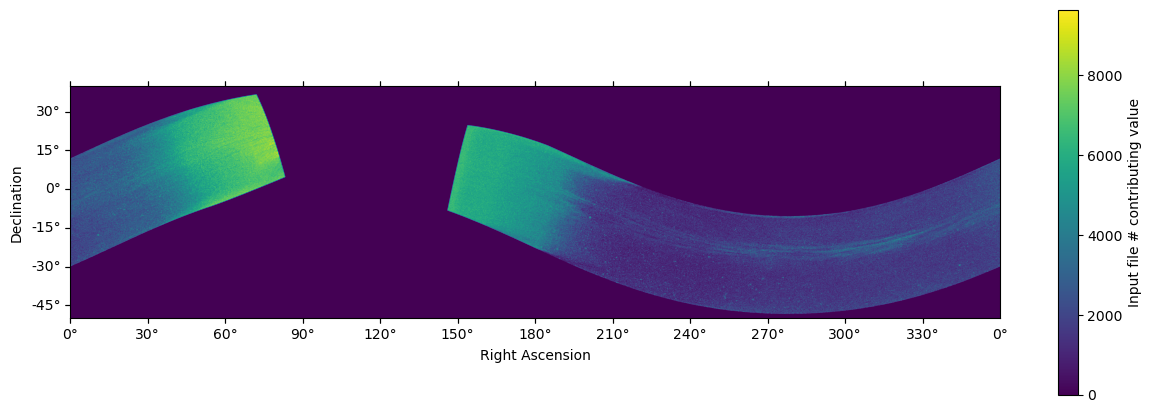

In [13]:
plt.figure(figsize=(15,5))
starfield.plot_attribution()
plt.colorbar(label='Input file # contributing pixel value')

With a small transformation, we can visualize the PSP encounter number that contributed the value in each pixel

In [19]:
idx_to_E = {i: utils.extract_encounter_number(ifiles[i], as_int=True) for i in range(len(ifiles))}
idx_to_E[-1] = np.nan

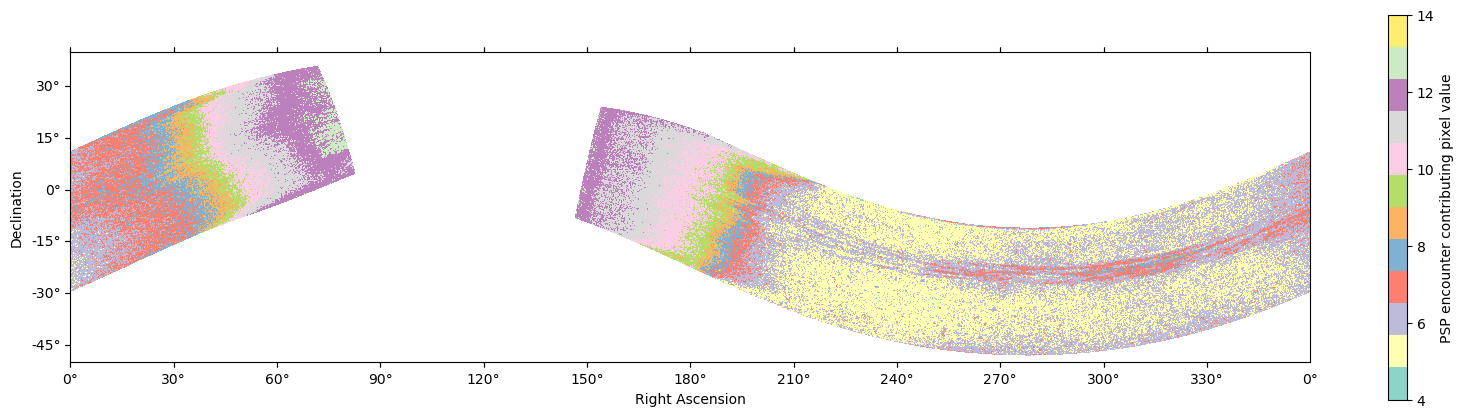

In [23]:
plt.figure(figsize=(20,5))
starfield.plot_attribution(mapper=lambda i: idx_to_E[i], cmap='Set3')
plt.colorbar(label="PSP encounter contributing pixel value")

# Subtracting the starfield

Now let's assemble a list of WISPR images ready for starfield subtraction (which is different from the list of pre-filtered images that went into the starfield estimation)

In [6]:
ifiles = []
ofiles = []
for E in range(4, 15):
    if2, of2 = utils.collect_files(f'/home/svankooten/psp/WISPR/realigned/WISPR_ENC{E:02d}_L3_FITS/')
    ifiles.extend(if2)
    ofiles.extend(of2)

In [48]:
# Here we use different options for WISPRImageProcessor---this is the second use case our processor supports
subtracted = starfield.subtract_from_image(
    ifiles[9200], processor=WISPRImageProcessor(mask=False, renormalize_starfield=True))

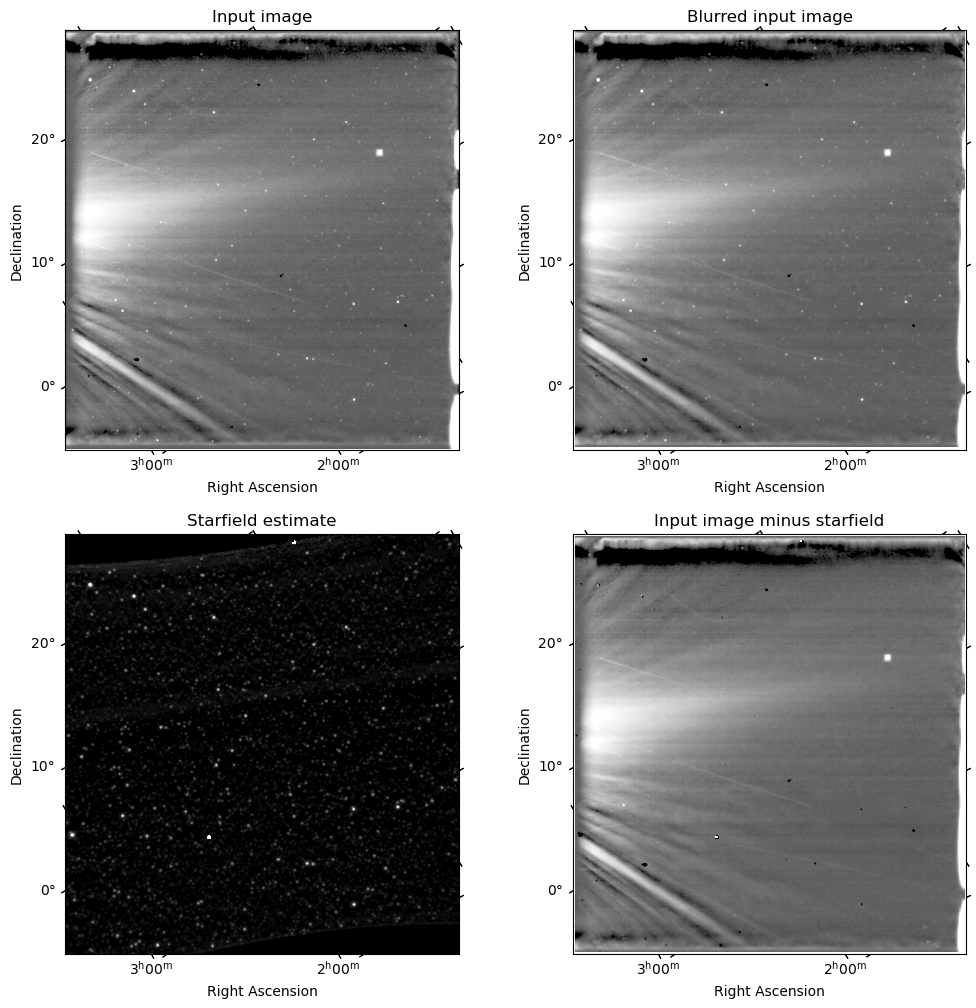

In [49]:
subtracted.plot_comparison(pmin=2)

In this subtracted image, aside from a number of coronal features and imager/stray light artefacts along the edge, points of note include

* The prominent dark spots, which are detector defects
* The planet in the upper-left corner
* A couple of bright dots in the lower-right corner, where bright stars weren't fully subtracted
* Slightly bipolar spots (dark and bright regions side-by-side) in the upper-left corner, indicating slight misalignments between the starfield estimate and the actual star (likely small inaccuracies in the lens distortion information in that corner)

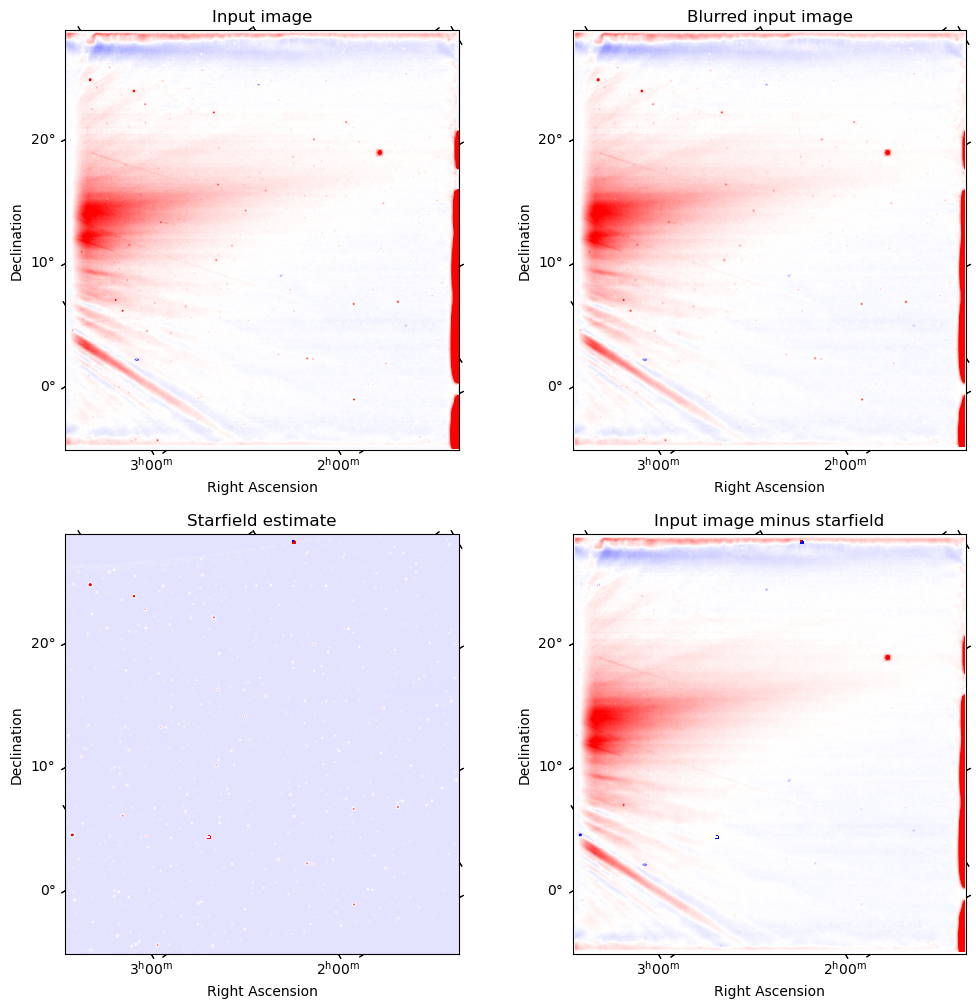

In [51]:
subtracted.plot_comparison(pmin=2, bwr=True)

This blue-white-red colorbar can help make small over- or under-subtractions stand out better

# Exploring the starfield-estimate quality

Now we do some more-quantitative goodness-of-subtraction analysis.

The below code loads in a number of images, runs the starfield subtraction, and then uses aperture photometry to record the fluxes of stars (a) after the image is loaded, (b) after blurries is applied to match the reprojection antialiasing, (c) on the starfield estimate itself, and (d) on what's left after starfield subtraction.

Then below, we produce a number of plots

In [ ]:
def extract_from_file(file, starfield):
    subtracted_image = starfield.subtract_from_image(file, WISPRImageProcessor(mask=False, denormalize_input=True))
    stars_x, stars_y, stars_vmag, stars_ra, stars_dec = remove_starfield.star_tools.find_expected_stars_in_frame(
        subtracted_image.wcs, trim=70,
        bright_cutoff=-20,
        dim_cutoff=9.5,
    )
    fluxes = []
    for x, y, vmag in zip(stars_x, stars_y, stars_vmag):
        flux = remove_starfield.star_tools.extract_flux(
            [subtracted_image.source_data, subtracted_image.blurred_data,
             subtracted_image.starfield_sample, subtracted_image.subtracted],
            x, y, aperture_r=6, annulus_thickness=2, gap=2, skip_edge_stars=True)
        if len(flux):
            flux = np.concatenate((flux, [vmag]))
            fluxes.append(flux)
    # Add WISPR-specific metadata
    E = utils.extract_encounter_number(file, as_int=True)
    t = utils.to_timestamp(file) - utils.to_timestamp(planets.get_psp_perihelion_date(E))
    fluxes = [np.concatenate((f, [E], [t])) for f in fluxes]
    return fluxes

with warnings.catch_warnings(), np.errstate(over='raise'):
    warnings.filterwarnings('ignore', message='.*All-NaN.*')
    all_fluxes = np.concatenate(process_map(extract_from_file, ifiles[::40], repeat(starfield)))

all_flux_data = pd.DataFrame({
    'orig_measured_flux': all_fluxes[:, 0],
    'blurred_measured_flux': all_fluxes[:, 1],
    'est_stellar_flux': all_fluxes[:, 2],
    'remnant_flux': all_fluxes[:, 3],
    'exp_magnitude': all_fluxes[:, 4],
    'E': all_fluxes[:, 5],
    'trel': all_fluxes[:, 6]})

f = (all_flux_data.blurred_measured_flux > 0) * (all_flux_data.est_stellar_flux > 0)
flux_data = all_flux_data[f]

Here we see that a star's flux in the starfield estimate is very well-correlated with the flux in any given input image (with this correlation loosening for very faint stars, when noise becomes dominant)

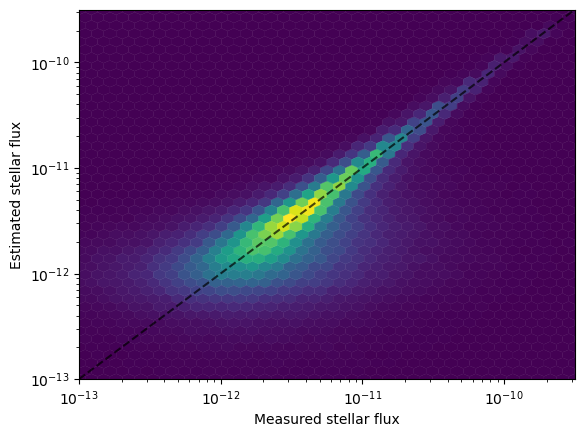

In [10]:
plt.hexbin(flux_data.blurred_measured_flux, flux_data.est_stellar_flux,
           xscale='log', yscale='log', linewidths=.3, gridsize=40, extent=(-13, -9.5, -13, -9.5))
plt.axline((1e-12, 1e-12), (1e-11, 1e-11), color='k', ls='--', alpha=.7)
plt.xlabel("Measured stellar flux")
plt.ylabel("Estimated stellar flux")
plt.autoscale(tight=True);

In [11]:
# This function is a by-eye estimated scale factor to convert catalog
# magnitude values to the summed fluxes extracted from WISPR images.
# (Estimation was done by finding the y-offset that makes the line in
# the plot below match the data cloud)
mag_to_wispr_flux = lambda mag: 3e-9 * 10**(mag / -2.5)

Here we can see that the stellar fluxes measured in each input image correlate well with their catalog magnitudes (with the same faint-star caveats)

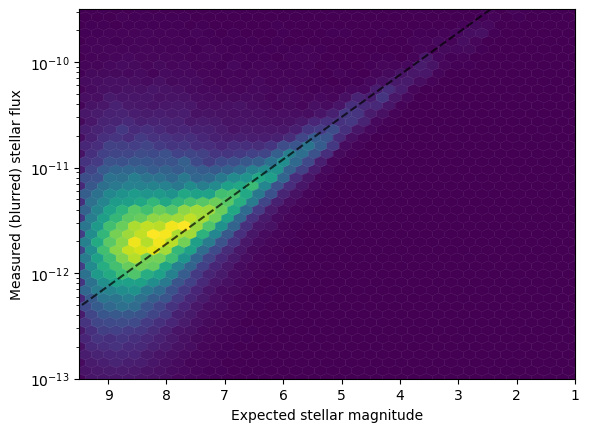

In [15]:
plt.hexbin(flux_data.exp_magnitude, flux_data.blurred_measured_flux, yscale='log', linewidths=.3, gridsize=40, extent=(9.5, 1, -13, -9.5))
plt.axline((8, mag_to_wispr_flux(8)), (6, mag_to_wispr_flux(6)), color='k', ls='--', alpha=.7)
plt.xlabel("Expected stellar magnitude")
plt.ylabel("Measured (blurred) stellar flux")
plt.autoscale(tight=True)
plt.xlim(*reversed(plt.xlim()));

Here we see the flux--magnitude correlation is even better when measuring the starfield estimate. This makes sense since the starfield represents a reduction of many separate measurements.

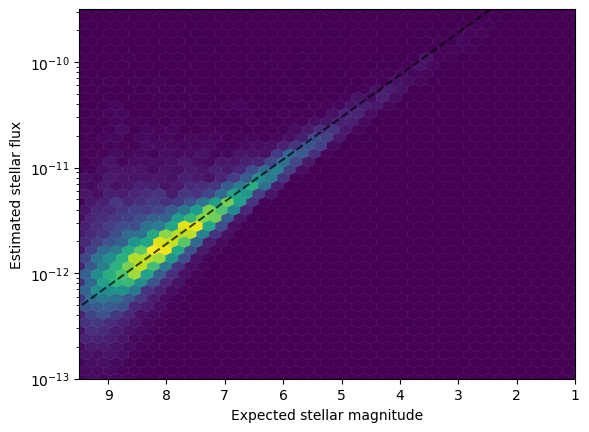

In [16]:
plt.hexbin(flux_data.exp_magnitude, flux_data.est_stellar_flux, yscale='log', linewidths=.3, gridsize=40, extent=(9.5, 1, -13, -9.5))
plt.axline((8, mag_to_wispr_flux(8)), (6, mag_to_wispr_flux(6)), color='k', ls='--', alpha=.7)
plt.xlabel("Expected stellar magnitude")
plt.ylabel("Estimated stellar flux")
plt.autoscale(tight=True)
plt.xlim(*reversed(plt.xlim()));

Here we see that the remnant flux (what's left after subtraction) as a fraction of the star's original flux is near 1 for faint stars where noise is dominant, and it's near zero for bright stars where noise affects little. It's encouraging to see both the zero values for bright stars, and the lack of a trend with stellar brightness (outside of the noise--no noise trend). That is to say, we're not handlign medium-brightness stars better or worse than bright stars.

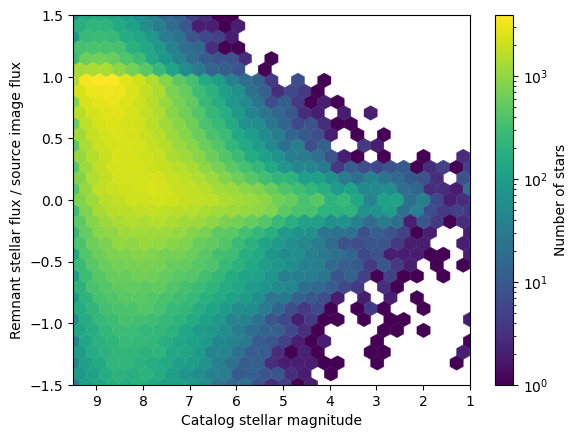

In [17]:
plt.hexbin(flux_data.exp_magnitude, flux_data.remnant_flux / flux_data.blurred_measured_flux, linewidths=.3, gridsize=30, extent=(9.5, 1, -1.5, 1.5), bins='log')
plt.xlabel("Catalog stellar magnitude")
plt.ylabel("Remnant stellar flux / source image flux")
plt.autoscale(tight=True)
plt.xlim(*reversed(plt.xlim()));
plt.colorbar().set_label("Number of stars");

Here is a pair of plots showing stellar fluxes measured before and after subtraction, respectively. The post-subtraction plot has lines marking where a star would be if its flux were decreased by a certain fraction, and we can see here that most stars are reduced if flux by well over 90%.

Text(0, 0.5, 'Post-subtraction remnant stellar flux (abs val)')

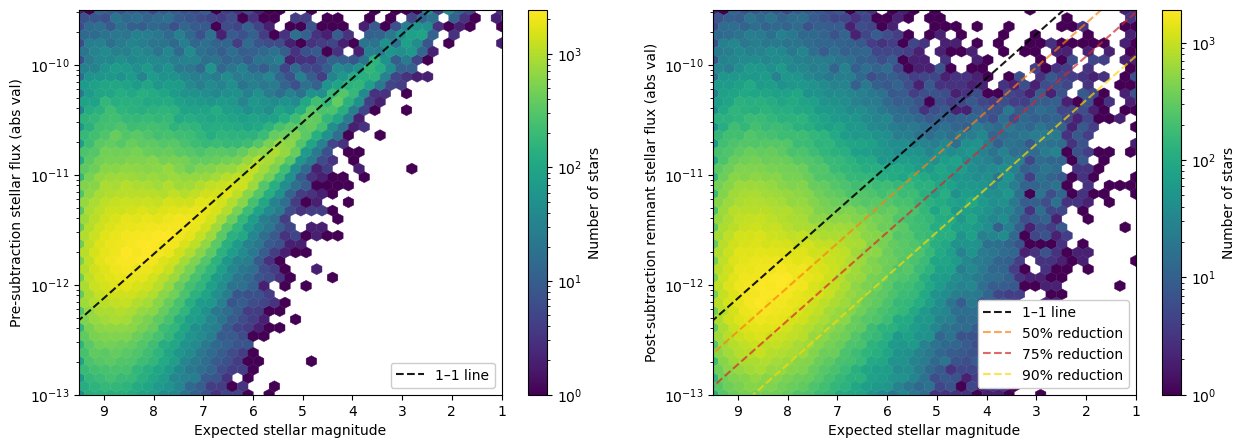

In [28]:
def make_plot(ydata, reductions):
    plt.hexbin(flux_data.exp_magnitude, np.abs(ydata), yscale='log', linewidths=.3, gridsize=40, extent=(9.5, 1, -13, -9.5), bins='log')
    plt.axline((8, mag_to_wispr_flux(8)), (6, mag_to_wispr_flux(6)), color='k', ls='--', alpha=.9, label='1–1 line')
    if reductions:
        plt.axline((8, .5*mag_to_wispr_flux(8)), (6, .5*mag_to_wispr_flux(6)), color='C1', ls='--', alpha=.7, label='50% reduction')
        plt.axline((8, .25*mag_to_wispr_flux(8)), (6, .25*mag_to_wispr_flux(6)), color='C3', ls='--', alpha=.7, label='75% reduction')
        plt.axline((8, .1*mag_to_wispr_flux(8)), (6, .1*mag_to_wispr_flux(6)), color='gold', ls='--', alpha=.7, label='90% reduction')
    plt.legend(loc='lower right', framealpha=1)
    plt.xlabel("Expected stellar magnitude")
    plt.autoscale(tight=True)
    plt.xlim(*reversed(plt.xlim()))
    plt.colorbar().set_label("Number of stars")
plt.figure(figsize=(15,5))
plt.subplot(121)
make_plot(flux_data.blurred_measured_flux, False)
plt.ylabel("Pre-subtraction stellar flux (abs val)")
plt.subplot(122)
make_plot(flux_data.remnant_flux, True)
plt.ylabel("Post-subtraction remnant stellar flux (abs val)")